## PHYS-467 Machine Learning for Physicists. Exercise session 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle, os
from urllib.request import urlopen 

from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, Lasso, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

np.random.seed(42)

# Exercise 1: Linear Regression (clarifications)

In this first exercise, we'll clarify the link between Gradient Descent, the pseudo-inverse and regularization for Ridge regression

**Question 1.a)** Generate a random $n\times{d}$ data matrix $X$ where $n=5$ and $d=10$. Generate an $n-$ dimensional _random_ label vector $y$.

In [2]:
n = 5
d = 10
X = np.random.randn(n, d)
y = np.random.randn(n)

**Question 1.b)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [3]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X,y)

**Question 1.c)** Recall that the OLS solution is given by $w = (X^TX)^{-1}X^Ty$. Note that when $n<d$, the matrix $X^TX$ is not invertible and we should resort to the pseudoinverse of $X$. In this case the solution reads $w = X^T(XX^T)^{-1}y$. Write a function that returns the solution calculated in this way and compare the so-obtained coefficients with those obtained by sklearn. What can you conclude?

In [4]:
def linear_regression_pi(X, y):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = X.T@np.linalg.inv(X.dot(X.T)).dot(y)
    return w

In [5]:
print(l_r.coef_)
print(linear_regression_pi(X,y))

[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]
[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]


**Question 1.c)** Another way to make the matrix invertible is to do Ridge Regression. Implement a function returning the regularized solution and compare with the solution obtained by sklearn's Ridge, use $\lambda=1$ for both cases.

In [6]:
def linear_regression_ridge(X, y, reg=1):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = (np.linalg.inv(X.T.dot(X)+reg*np.eye(X.shape[1]))@X.T).dot(y)
    return w

In [7]:
ridge_regression = Ridge(fit_intercept=False, alpha=1)
l_r = ridge_regression.fit(X,y)

In [8]:
print(l_r.coef_)
print(linear_regression_ridge(X,y))

[ 0.01740638  0.34219209 -0.07836338  0.21009139 -0.04502128 -0.28256825
  0.1541607  -0.00409031  0.14698769 -0.27264937]
[ 0.01740638  0.34219209 -0.07836338  0.21009139 -0.04502128 -0.28256825
  0.1541607  -0.00409031  0.14698769 -0.27264937]


**Question 1.d)** Use a small regularization parameter, say $\lambda = 0.001$ and compare the output of Ridge regression with the pseudo-inverse. What do you notice ?

In [9]:
ridge_regression = Ridge(fit_intercept=False, alpha=1e-3)
l_r = ridge_regression.fit(X,y)

In [10]:
print(linear_regression_pi(X,y))
print(l_r.coef_)

[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]
[ 0.05134814  0.46791045 -0.13253147  0.2731596  -0.03923451 -0.36129243
  0.16612544 -0.00733704  0.24171301 -0.37580269]


**Question 1.e)** Compute the square error on the training data, obtained by using the pseudoinverse coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [11]:
ridge_regression = Ridge(fit_intercept=False, alpha=0.1)
l_r = ridge_regression.fit(X,y)

w_pi = linear_regression_pi(X,y)

In [12]:
error_ridge = np.mean((l_r.predict(X)-y)**2)
print(error_ridge)

error_pi = np.mean((X@w_pi-y)**2)
print(error_pi)

0.00045877940311019424
7.642090019328552e-32


**Question 1.f)** Consider the OLS problem and implement a function performing one step of gradient descent w.r.t. the parameters. Implement a second function calling the first function for M iterations and finally returning the optimal parameters.

In [13]:
def gradient_descent_step(X,y,w,eta):
    """
    Do one gradient step of OLS
    """
    grad = X.T@(X@w-y)
    w = w - eta * grad 
    return w

def train(n_iter,X,y,w,eta):
    for i in tqdm(range(n_iter)):
        w = gradient_descent_step(X,y,w,eta)
    return w

In [14]:
w_init_1 = np.random.randn(d)
w_b = train(5000,X,y,w_init_1,0.01)
print(w_b)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 205086.40it/s]

[ 0.32195506 -0.52445035 -0.68249123  0.86001682  0.17927919 -1.0671358
 -0.14065812 -0.60751288 -0.14952196 -0.6743147 ]


**Question 1.g)** Compute 1) $w_a$ the parameters obtained by initializing gradient descent with a vector of zeroes, and $w_b$ the parameters obtained by initializing gradient descent with a vector of ones. Compare both $w_a$ and $w_b$ with the solution obtained by the pseudo-inverse. What do you notice ?

In [15]:
w_init_0 = np.zeros(d)
w_a = train(5000,X,y,w_init_0,0.01)
print(w_a)
print(w_pi)

# == 

w_init_1 = np.ones(d)
w_b = train(5000,X,y,w_init_1,0.01)
print(w_b)
print(w_pi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 208170.57it/s]


[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]
[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 230681.88it/s]

[-0.20032023  1.31127431  0.87438817 -0.28143709  0.07610369  0.21457974
  0.37226861  0.5765021   0.68453299 -0.32013639]
[ 0.05140553  0.46808963 -0.13261446  0.2732456  -0.03921823 -0.36139712
  0.16613153 -0.00734326  0.24185646 -0.37594695]


**Question 1.h)** Generate a random data $n\times{d}$ matrix $X$ where $n=10$ and $d=5$. Generate an $n-$dimensional label vector $y$.

In [16]:
n = 10
d = 5
X = np.random.randn(n, d)
y = np.random.randn(n)

**Question 1.i)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [17]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X,y)

**Question 1.l)** Write a function returning the standard OLS solution and compare it with the sklearn's solution

In [18]:
def linear_regression(X, y):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = np.linalg.inv(X.T.dot(X))@X.T.dot(y)
    return w

In [19]:
print(linear_regression(X,y))
print(l_r.coef_)

[-0.38149748 -0.19937711  0.33513045 -0.21828125 -0.10611849]
[-0.38149748 -0.19937711  0.33513045 -0.21828125 -0.10611849]


**Question 1.m)** Calculate the error obtained by using the OLS coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [20]:
ridge_regression = Ridge(fit_intercept=False, alpha=1e-1)
l_r = ridge_regression.fit(X,y)

w_lr = linear_regression(X,y)

In [21]:
error_ridge = np.mean((l_r.predict(X)-y)**2)
print(error_ridge)

error_pi = np.mean((X@w_lr-y)**2)
print(error_pi)

0.6851858037148497
0.6851163705112125


**Question 1.n)** Use the GD function implemented before and compare the solution it finds with the one found by sklearn's LinearRegression.

In [22]:
w_init = np.ones(d)
w_gd = train(5000,X,y,w_init,0.01)
print(w_lr)
print(w_gd)
print(np.mean((X@w_gd-y)**2))
print(np.mean((X@w_lr-y)**2))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 214524.85it/s]

[-0.38149748 -0.19937711  0.33513045 -0.21828125 -0.10611849]
[-0.38149748 -0.19937711  0.33513045 -0.21828125 -0.10611849]
0.6851163705112124
0.6851163705112125


# Exercise 2 : (Stochastic) Gradient Descent with Logistic regression

**Question 2.a)** Implement the sigmoid function given an input $x$.

In [23]:
sigmoid = lambda x: 1/(1+np.exp(-x))

**Question 2.b)** Generate an $n\times{d}$ random data matrix. Generate a random vector of optimal parameters $w_{opt}$. Generate the labels as y     = 2 * np.random.binomial(1,sigmoid(X @ w_opt)) - 1.0

In [24]:
n = 100
d = 2

w_opt = np.random.normal(size=d)
X     = np.random.normal(size=(n,d))
y     = 2 * np.random.binomial(1,sigmoid(X @ w_opt)) - 1.0

**Question 2.c)** Verify that sigmoid(x) = 1-sigmoid(x)

In [25]:
print(sigmoid(X[1]))
print(1-sigmoid(-X[1]))

[0.37672423 0.17499047]
[0.37672423 0.17499047]


**Question 2.d)** Implement a function performing one step gradient descent for logistic regression. Remember that the gradients are given by $X^T\sigma(Xw-y)$. Pay attention to the fact that this equation assumes the label to be either 0 or 1. Implement a second function enabling multiple iterations of gradient descent. This function should return the parameters calculated at each iteration.

In [59]:
def gradient_step_logistic(X, y, w_, lr=0.01):
    #return w - lr * np.einsum('ij,j->i', X.T,(sigmoid(y * (X @ w)) - 1.0)*y)
    return w_ - lr * (X.T@((sigmoid(y*(X@w_))-1)*y))

def gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100):
    w = w_init
    ws = []
    for i in range(n_iter):
        # compute the gradient of logistic loss with y = -1 or y = 1
        w = gradient_step_logistic(X, y, w, lr)    
        ws.append(w)
    return ws

**Question 2.e)** Implement stochastic gradient descent using the gradient step function used in the previous question. Hint: you should apply the gd function only on a random subset of the data at each iteration.

In [60]:
def stochastic_gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100):
    w = w_init
    ws = []
    batch_size = 10
    for i in range(n_iter):
        indices = np.random.randint(0, X.shape[0], size=batch_size)
        w = gradient_step_logistic(X[indices], y[indices], w, lr)
        ws.append(w)
    return ws

**Question 2.f)** Plot the correlation $w_t \cdot w_{\star}$ as a function of the number of iterations $t$ for Gradient Descent and Stochastic Gradient Descent. 

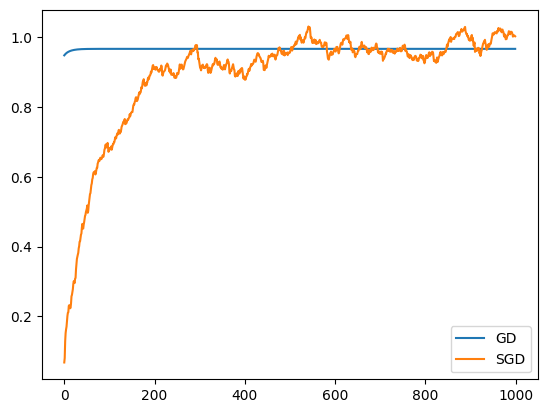

In [61]:
ws_gd  = gradient_descent_logistic(X, y, np.zeros(d), lr=1e-2, n_iter=1000)
ws_sgd = stochastic_gradient_descent_logistic(X, y, np.zeros(d), lr=1e-2, n_iter=1000)

plt.plot(ws_gd @ w_opt / (np.linalg.norm(ws_gd, axis=1)* np.linalg.norm(w_opt)), label='GD')
plt.plot(ws_sgd @ w_opt / (np.linalg.norm(ws_gd, axis=1)* np.linalg.norm(w_opt)), label='SGD')
plt.legend()
plt.show()

**Question 2.g)** Use sklearn's LogisticRegression with fit_intercept=False and compare its accuracy with that obtained by gd and the optimal parameters.

In [62]:
logistic_regression = LogisticRegression(fit_intercept=False)
lr = logistic_regression.fit(X,y)

In [63]:
print(np.sum(((2*(sigmoid(X@lr.coef_[0])>0.5).astype(int))-1==y))/len(y))
print(np.sum(((2*(sigmoid(X@ws_gd[-1])>0.5).astype(int))-1==y))/len(y))
print(np.sum(((2*(sigmoid(X@w_opt)>0.5).astype(int))-1==y))/len(y))

0.79
0.79
0.82


# Exercise 3: LASSO

**Question 3.a)** Generate a $n\times{d}$ matrix with entries drawn from a Gaussian with zero mean and unit variance. Choose $n=300$ and $d=10$.

In [64]:
rng = np.random.RandomState(42)
n = 300
d = 10
X_train = rng.randn(n, d)

**Question 3.b)** Given the vector $w_{opt}$ provided below, print it and use it to generate the training and testing labels. Corrupt the labels with zero-mean unit-variance Gaussian noise

In [65]:
w_opt = rng.choice([0,1,-1],d,p=[0.7,0.15,0.15])
print(w_opt)
y_train = X_train@w_opt+ 1*rng.randn(n)

[ 1 -1  0 -1  0  0  0  0  0  0]


**Question 3.c)** Perform linear regression on the training data and print: a) the so-found coefficients and the train error

In [66]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X_train,y_train)
print(l_r.coef_)
print(np.mean((l_r.predict(X_train)-y_train)**2))

[ 0.9810048  -0.96923952  0.03324104 -0.98097451  0.06136124  0.03222384
 -0.04996516 -0.00965523  0.03963248 -0.04502694]
1.0240993371444587


**Question 3.d)** Fit sklearn's LASSO on the training data and print: a) the so-found coefficients and the train error. Fix the regularization to 0.1. Look at the coefficients, what do you notice?

In [67]:
lasso = Lasso(fit_intercept=False,alpha=0.1)
l_r = lasso.fit(X_train,y_train)
print(l_r.coef_)
print(np.mean((l_r.predict(X_train)-y_train)**2))

[ 0.86307721 -0.86313438  0.         -0.86677229  0.          0.
 -0.         -0.          0.         -0.        ]
1.0704323417919932


**Question 3.e)** Use cross validation to find the optimal value of the regularization strength in Lasso. Plot the different coefficients as a function of $\lambda$ 

/home/biggio/exercise4/exercise/lib/python3.10/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/biggio/exercise4/exercise/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/biggio/exercise4/exercise/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.169e+02, tolerance: 4.744e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

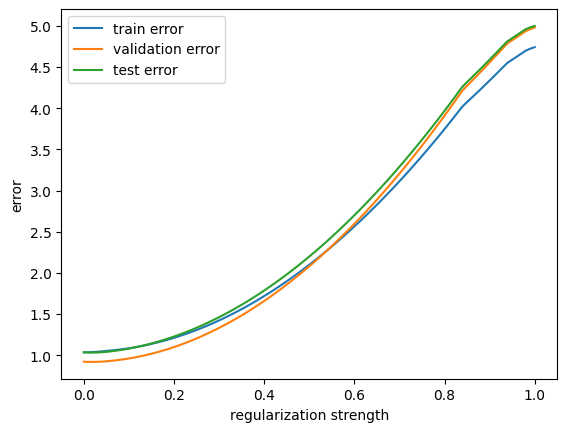

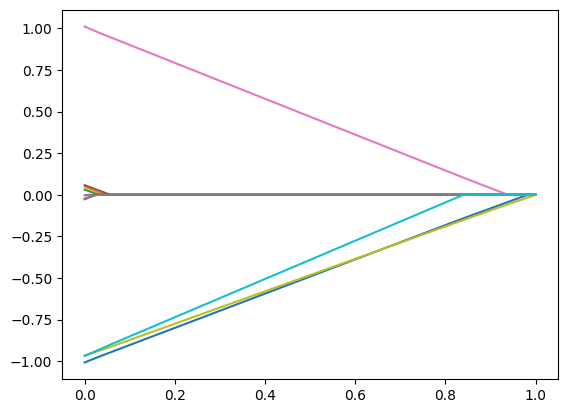

In [68]:
rng = np.random.RandomState(10)
n = 1000
d = 10
X_train = rng.randn(n, d)
X_val = rng.randn(n, d)
X_test = rng.randn(n, d)

w_opt = rng.choice([0,1,-1],d,p=[0.7,0.15,0.15])
#print(w_opt)
y_train = X_train @ w_opt + rng.randn(n)
y_val = X_val @ w_opt + rng.randn(n)
y_test = X_test @   w_opt + rng.randn(n)

lambdas = np.linspace(0, 1.0, 100)
train_errors=[]
val_errors=[]
test_errors=[]
ws = []

for l in lambdas:
    lasso = Lasso(fit_intercept=False,alpha=l)
    l_r = lasso.fit(X_train,y_train)
    ws.append(l_r.coef_)
    train_errors.append(np.mean((l_r.predict(X_train)-y_train)**2))
    val_errors.append(np.mean((l_r.predict(X_val)-y_val)**2))
    test_errors.append(np.mean((l_r.predict(X_test)-y_test)**2))

plt.plot(lambdas,train_errors, label='train error')
plt.plot(lambdas,val_errors, label='validation error')
plt.plot(lambdas,test_errors, label='test error')
plt.xlabel('regularization strength')
plt.ylabel('error')
plt.legend()
plt.show()

# plot the coefficients 

plt.plot(lambdas, ws) ### i don't undertand this
plt.show()

In [69]:
lambdas[np.argmin(val_errors)]

0.020202020202020204

In [70]:
print(ws[np.argmin(val_errors)])
print(w_opt)

[-0.98496926  0.02637582  0.01134308 -0.00393351 -0.          0.03720723
  0.9868559  -0.00410678 -0.94726365 -0.94413589]
[-1  0  0  0  0  0  1  0 -1 -1]


# Exercise 4: Ridge Classification, Logistic Regression

In this exercise we first consider a synthetic dataset to compare Ridge and Logistic regression for classification

**Question 4.a)** Use the sklearn function make_classification to generate 1000 data samples in 2 dimension. Use the following arguments: n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12. Then use train_test_split with the following arguments X, y, test_size=0.2, random_state=42, to generate training and test splits.

In [73]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Question 4.b)** Make a scatter plot of the training data. Color each point according to its cluster assignment. Hint use c=y in plt.scatter.

Text(0, 0.5, '$x_2$')

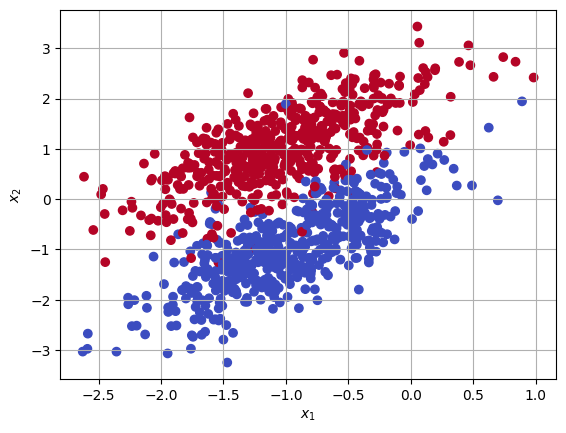

In [74]:
# scatter X and color the points depending on their class
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

**Question 4.c)** Train a ridge classifier and a logistic regression using sklearn. Compare the results in terms of accuracy.

In [76]:
# Create and train a Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, y_train)

# Create and train a Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Make predictions using both models
y_pred_ridge = ridge_classifier.predict(X_test)
y_pred_logistic = logistic_regression.predict(X_test)

# Calculate accuracy for both models
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

**Question 4.d)** Plot the decision boundaries of the two models using the function below. 

In [77]:
def plot_decision_boundaries(X_test,y_test,ridge_classifier,logistic_regression,accuracy_ridge,accuracy_logistic):
    # Plot the decision boundary for Ridge Classifier
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Ridge Classifier\nAccuracy: {accuracy_ridge:.2f}")
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = ridge_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    
    # Plot the decision boundary for Logistic Regression
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Logistic Regression\nAccuracy: {accuracy_logistic:.2f}")
    ax = plt.gca()
    Z = logistic_regression.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    
    plt.show()

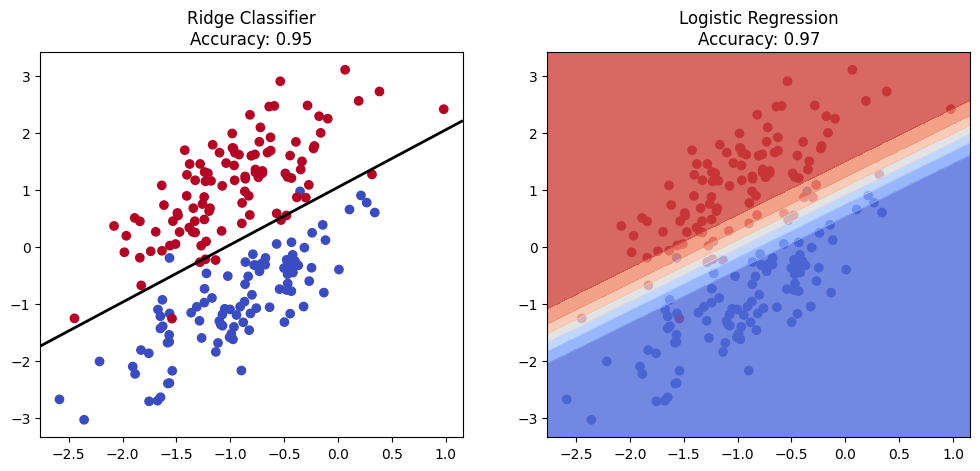

In [78]:
plot_decision_boundaries(X_test,y_test,ridge_classifier,logistic_regression,accuracy_ridge,accuracy_logistic)

**Question 4.e)** Implement ridge classification from scratch. Implement two functions: one should return the weights and biases, the other should return the classification results given the inputs and the previously obtained coefficients. Add the option to include a regularization parameter.

In [96]:
def ridge_classifier_train(X,y,alpha):
    n_samples, n_features = X.shape
    X_augmented = np.column_stack((X, np.ones(n_samples)))  # Add a bias term

    identity_matrix = np.eye(n_features + 1)
    coefficients = np.linalg.inv(X_augmented.T @ X_augmented + alpha * identity_matrix) @ X_augmented.T @ y

    coef_ = coefficients[:-1]
    intercept_ = coefficients[-1]
    return coef_, intercept_

def ridge_classifier_predict(X,coef_,intercept_):
    preds = X @ coef_ + intercept_
    return np.sign(preds)

**Question 4.f)** Plot the decision boundary and compare it with that obtained via sklearn. Use alpha = 1.

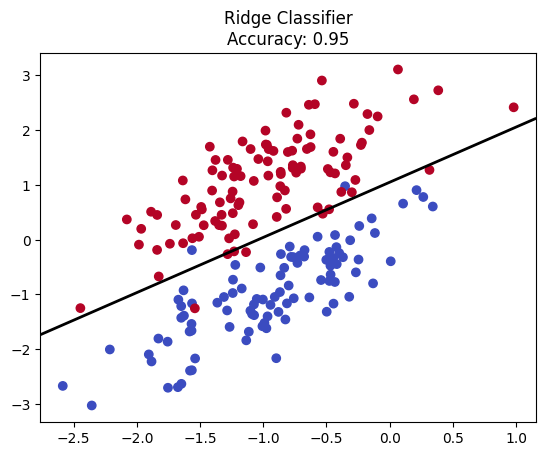

In [97]:
# Create and train a Ridge Classifier
coef_, intercept_ = ridge_classifier_train(X_train, ((y_train-0.5)*2),alpha=1)
y_pred_ridge_custom = ridge_classifier_predict(X_test,coef_,intercept_)

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
plt.title(f"Ridge Classifier\nAccuracy: {np.sum(y_pred_ridge_custom==((y_test-0.5)*2))/(len(y_test)):.2f}")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = ridge_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Exercise 5: Classification on the Ising model 

We will now apply regression to the Ising model to predict the phase of the system. 

In [98]:
# Ising model parameters

L=40 # linear system size
J=-1.0 # Ising interaction
#T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

**Question 5.a)**

1) Load the data using the provided function `load_data`, then split the data in three categories : the first 70000 samples are configurations in the ordered phase, the next 30000 samples are in the critical phase and the last 60000 samples are in the disordered phase.

2) Merge the ordered and disordered samples together, use half of them for a training set and the rest for a validation set.

In [99]:
def load_data():
    # url to data
    url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';
    ######### LOAD DATA
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"
    #DATA
    data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    #LABELS (convention is 1 for ordered states and 0 for disordered states)
    labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)
    return data, labels


In [100]:
data, labels = load_data()
print(len(data))

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

160000
X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


**Question 5.b)** Plot one instance of each class

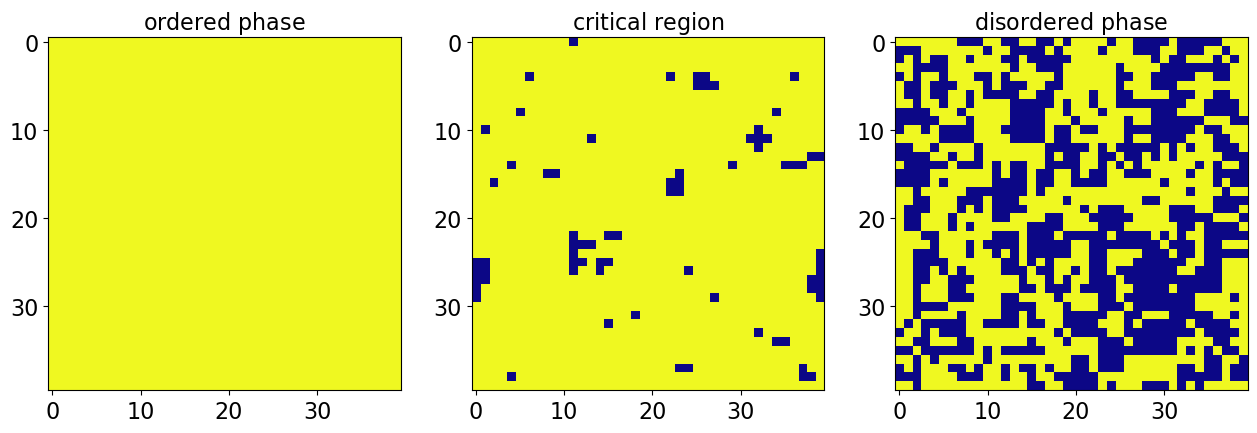

In [193]:
# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[1000].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50000].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

**Question 5.c)** Train a Ridge and Logistic regression model using different regularization and evaluate the performance on the validation set and the samples in the critical phase. What do you notice ?
_Note_ : Training the models might take some time 

In [210]:
# define regularisation parameter
lmbdas=np.logspace(-3,2,20)

# preallocate data
train_accuracy_log=np.zeros(lmbdas.shape,np.float64)
test_accuracy_log=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_log=np.zeros(lmbdas.shape,np.float64)

train_accuracy_ridge   =np.zeros(lmbdas.shape,np.float64)
test_accuracy_ridge    =np.zeros(lmbdas.shape,np.float64)
critical_accuracy_ridge=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in tqdm(enumerate(lmbdas)):

    # define logistic regressor
    logreg= LogisticRegression(C=1.0/lmbda)
    ridge = RidgeClassifier(alpha = lmbda)

    # fit training data
    logreg.fit(X_train, Y_train)
    ridge.fit(X_train, Y_train)

    # check accuracy
    train_accuracy_log[i]=logreg.score(X_train,Y_train)
    test_accuracy_log[i]=logreg.score(X_test,Y_test)
    critical_accuracy_log[i]=logreg.score(X_critical,Y_critical)

    train_accuracy_ridge[i]=ridge.score(X_train,Y_train)
    test_accuracy_ridge[i]=ridge.score(X_test,Y_test)
    critical_accuracy_ridge[i]=ridge.score(X_critical,Y_critical)

20it [02:16,  6.81s/it]


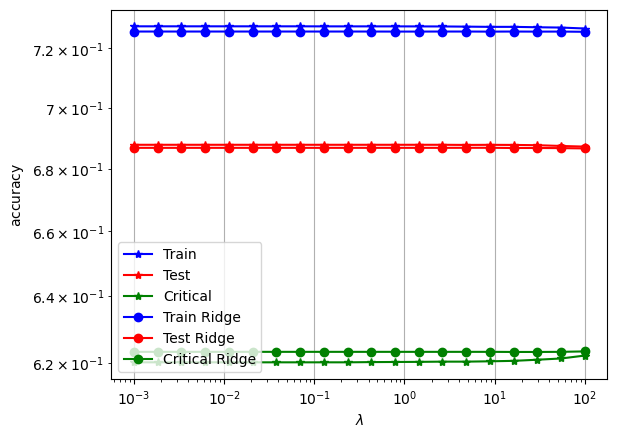

In [212]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy_log,'*-b',label='Train')
plt.semilogx(lmbdas,test_accuracy_log,'*-r',label='Test')
plt.semilogx(lmbdas,critical_accuracy_log,'*-g',label='Critical')

plt.semilogx(lmbdas,train_accuracy_ridge,'o-b',label='Train Ridge')
plt.semilogx(lmbdas,test_accuracy_ridge,'o-r',label='Test Ridge')
plt.semilogx(lmbdas,critical_accuracy_ridge,'o-g',label='Critical Ridge')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.yscale('log')
plt.grid()
plt.legend()

plt.show()